# Notebook to format data provided by Baglione lab. Currently unpublished

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import scipy.io as sio
from pathlib import Path
import IPython.display as ipd
from tqdm import tqdm

In [4]:
# Specify data filepaths

#raw_data_dir = Path('/home/jupyter/behavior_data_local/data/raw/baglione_crows')
raw_data_dir = Path('/home/jupyter/behavior_data_local/data/raw/baglione_crows')
formatted_data_dir = Path('/home/jupyter/behavior_data_local/data/formatted/baglione_crows')

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
#annotations_fp = raw_data_dir.joinpath('labelled_datasets_individual_vocalizations_classification_with_file.csv')
annotations_dir = Path(raw_data_dir, 'Behavior_annotations')

data_fps = sorted(raw_data_dir.glob('*.csv'))
annotations_fps = sorted(annotations_dir.glob('*.csv'))

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 50 # They provide up to 1000 Hz, but we use 50
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'baglione_crows'

In [6]:
# Convenience functions

def data_fp_to_clip_id(x):
    return x.stem[:-4]

def annotation_fp_to_clip_id(x):
    p = x.stem.split('_')
    return '_'.join(['19', p[1], p[2], p[3][-2:]])

# def clip_id_to_data_fp(y):
#     y = y.split('_')
#     return raw_data_dir.joinpath('data').joinpath('19').joinpath(y[0]).joinpath(y[1]).joinpath(y[2]+'.swv')

def clip_id_to_data_fp(y):
    return Path(raw_data_dir, y + '_acc.csv')

In [7]:
# Get list of clip ids

clip_ids = sorted([data_fp_to_clip_id(x) for x in data_fps])

# data_fps = [raw_data_dir + '/' + clip_id + '/' +clip_id +'prh_speed.mat' for clip_id in clip_ids]

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [8]:
## Integer codes for individuals

clip_id_to_individual = {}
for clip_id in clip_ids:
    y = clip_id.split('_')
    clip_id_to_individual[clip_id] = y[0] + '_' + y[1] + '_' + y[2]
     
individuals = sorted(set(clip_id_to_individual[y] for y in clip_ids))

## Integer codes for individuals

individual_to_individual_id = {individual : i for i, individual in enumerate(individuals)}
clip_id_to_individual_id = {clip_id : individual_to_individual_id[clip_id_to_individual[clip_id]] for clip_id in clip_ids}
    

dataset_metadata['individual_ids'] = [individual_to_individual_id[x] for x in individuals]
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [9]:
# Set up data splits: divide individuals across folds for cross validation

n_folds = 5
dataset_metadata['n_folds'] = n_folds
individuals_per_fold = {i : [] for i in range(n_folds)}

for pointer, individual in enumerate(dataset_metadata['individual_ids']):
    individuals_per_fold[pointer % n_folds].append(individual)
    
dataset_metadata['individuals_per_fold'] = individuals_per_fold
    
print(individuals_per_fold)
print("There are %d individuals" % len(individuals))

{0: [0, 5, 10], 1: [1, 6], 2: [2, 7], 3: [3, 8], 4: [4, 9]}
There are 11 individuals


In [10]:
# Set up clip ids 

clip_ids_per_fold = {i : [] for i in range(n_folds)}
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    for fold in range(n_folds):
        if individual in individuals_per_fold[fold]:
            clip_ids_per_fold[fold].append(clip_id)
for fold in range(n_folds):
    clip_ids_per_fold[fold] = sorted(clip_ids_per_fold[fold])

dataset_metadata['clip_ids_per_fold'] = clip_ids_per_fold
dataset_metadata['clip_ids'] = clip_ids

## Create dataset-level metadata

In [11]:
## Integer codes for specific behaviors

beh_names = ['unknown',
             'flying',
             'in_nest']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}


In [12]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [13]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [14]:
# Convenience function to detect nans.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

#Interpolates all nan values of given array
def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [15]:
# For each clip, create and save the data in the correct format

total_dur_samples = 0
total_annotation_dur_samples = 0

for annotation_fp in tqdm(annotations_fps):
    clip_id = annotation_fp_to_clip_id(annotation_fp)
    
    # load features
    data_fp = clip_id_to_data_fp(clip_id)
    data  = pd.read_csv(data_fp, header = None).values
    
    dur = np.shape(data)[0]
    clip_data = np.zeros((dur, 5))
    total_dur_samples += dur
    
    # correct for gravity
    for i in [0, 1, 2]: 
        x = data[:, i]
        x = interpolate_nan(x)
        clip_data[:, i] = x
    
    # load annotations
    annotations = pd.read_csv(annotation_fp)
    
    # reformat annotations
    per_frame_annotations = np.zeros(dur) # populate with 0's, aka "unknown"
    for i, row in annotations.iterrows():
        int_label = row['label']
        start_sample = int(row['start_sec'] *sr)
        end_sample = int(row['end_sec'] *sr)
        per_frame_annotations[start_sample: end_sample] = int_label

    clip_data[:, -1] = per_frame_annotations

    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    clip_data[:, -2] = individual_id
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",", fmt='%.9e')
    
    clip_annotation_dur_samples = np.sum(per_frame_annotations > 0)
    total_annotation_dur_samples += clip_annotation_dur_samples
    

100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


In [16]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total_annotation_dur_sec = total_annotation_dur_samples / sr
total_annotation_dur_hours = total_annotation_dur_sec / 3600
print("total annotation duration is %f seconds, i.e. %f hours" % (total_annotation_dur_sec, total_annotation_dur_hours))

total duration is 280873.380000 seconds, i.e. 78.020383 hours
total annotation duration is 12085.000000 seconds, i.e. 3.356944 hours


## Check it all looks ok

In [17]:
clip_id = clip_ids[-1]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.array(pd.read_csv(clip_data_fp, delimiter = ',', header = None))
#data = np.load(clip_data_fp)

In [18]:
np.shape(data)

(353684, 5)

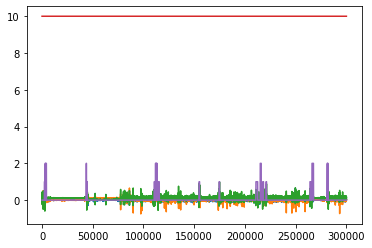

In [19]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:300000, i])

## Plot Dataset Summary

In [20]:
# Count class representation

beh_names = dataset_metadata['label_names']
label_count = {fold : {name : 0 for name in beh_names} for fold in range(n_folds)}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        for fold in range(n_folds):
            if clip_id in dataset_metadata['clip_ids_per_fold'][fold]:
                label_count[fold][name] += counts[key]
                
label_perc = {fold : {name : 0 for name in beh_names[1:]} for fold in range(n_folds)}

for name in beh_names[1:]:
    for fold in range(n_folds):
        label_perc[fold][name] = label_count[fold][name] / sum([label_count[fold][j] for j in beh_names[1:]])


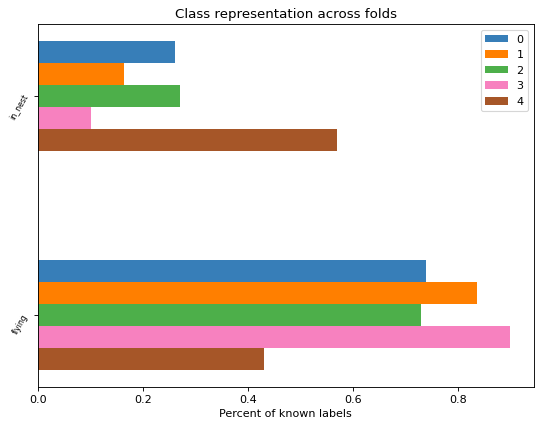

In [21]:
# Plot class representation

# https://gist.github.com/thriveth/8560036#file-cbcolors-py
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.1
plt.figure(figsize=(8, 6), dpi=80)

for fold in range(n_folds):
    current_offset = -(fold - n_folds // 2)*offset
    plt.barh(keys +current_offset, [label_perc[fold][beh_names[key]] for key in keys], height=width, align='center', label = fold, color = CB_color_cycle[fold])
    
plt.title("Class representation across folds")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
with open(numerical_target_fp, 'w') as file:
    yaml.dump(label_perc, file)

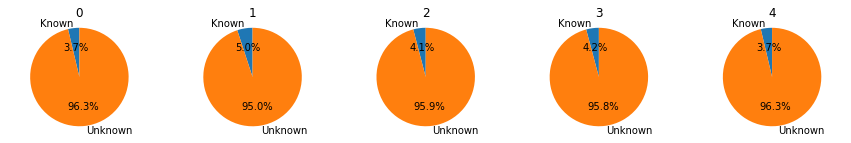

In [22]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
sizes = {fold : [sum([label_count[fold][j] for j in beh_names[1:]]), label_count[fold]['unknown']] for fold in range(n_folds)}
# train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
# val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
# test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,n_folds, figsize = (3*n_folds,2))

for fold in range(n_folds):
    ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[fold].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[fold].set_title(fold)

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()


## Temporal Statistics

In [23]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if len(list_of_labels) > 0:
        if list_of_labels[-1] == unknown_value:
            del list_of_labels[-1]
            del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

Mean overall label duration is 14.135 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/baglione_crows/dataset_metadata.yaml
